In [56]:
import pyactup as pau
import random
from copy import copy

import math
from math import log
from math import exp

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FixedFormatter
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns
sns.set_style("whitegrid")

# Cepeda's Data

In [6]:
cepeda = pd.read_csv("cepeda_recall.csv")
cepeda

,RI,Spacing,Accuracy
0,35,0.00256,0.522955
1,35,1.00000,0.690765
2,35,4.00000,0.738259
3,35,7.00000,0.804749
4,35,11.00000,0.822164
5,35,21.00000,0.758839
6,35,105.00000,0.598945
7,7,0.00256,0.887071
8,7,1.00000,0.978892
9,7,2.00000,0.956728


Text(0.5, 0.98, 'Spacing Effect')

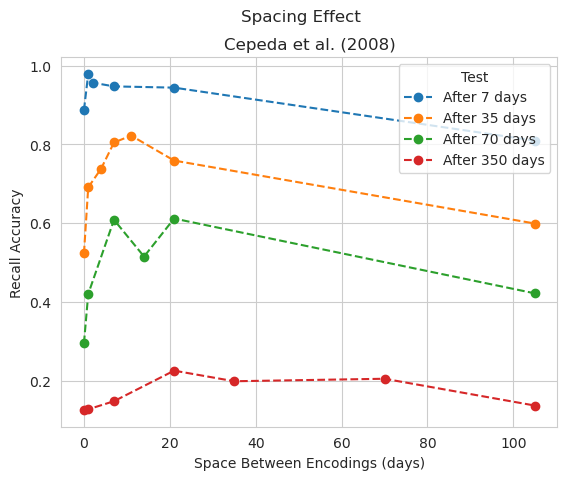

In [36]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]], loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Cepeda et al. (2008)")
fig.suptitle("Spacing Effect")

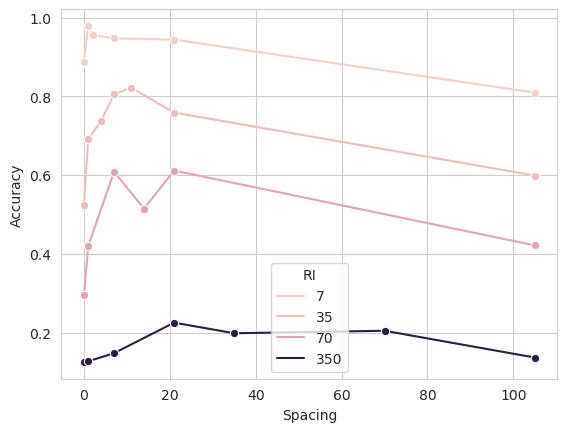

In [15]:
sns.lineplot(cepeda, x="Spacing", y="Accuracy", hue="RI", marker="o")
plt.show()

# Standard ACT-R model

In ACT-R, the activation of a memory depends on the accumulation of identically decaying traces:

\begin{equation}
    A(m, t) = \sum_i (t - t_j)^{d_i}
\end{equation}

This model, alone, cannot account for the spacing effect

In [60]:

np.array(cepeda.Accuracy[cepeda.RI==7])
np.array(results[7])

array([0.92730366, 0.91813382, 0.91017501, 0.88154186, 0.84027664,
       0.76956857])

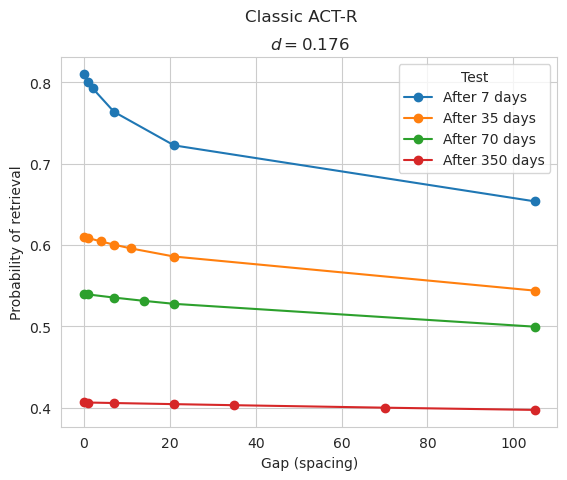

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.826277024227553
        x: [ 1.763e-01]
      nit: 5
      jac: [ 4.796e-06]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [65]:
# Cepeda's experiment design
design = {7 : [0.00256, 1, 2, 7, 21, 105],
          35 : [0.00256, 1, 4, 7, 11, 21, 105],
          70 : [0.00256, 1, 7, 14, 21, 105],
          350 : [0.00256, 1, 7, 21, 35, 70, 105]}


# Convert days into seconds
daysec = 24 # 60*60*24
d_default = .15

def actr(design, d=d_default):
    """Standard ACT-R simulation of a spacing effect design"""
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t = (ri + gap)*daysec
            t1 = 0
            t2 = gapsec
            odds1 = (t - t1)**-d
            odds2 = (t - t2)**-d 
            odds = odds1 + odds2
            prob = odds / (odds + 1)
            ri_results.append(odds)
        results[ri] = ri_results
    return results

def actrMSE(x):
    """Function for global optimization"""
    global design 
    d = x[0]
    results = actr(design, d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE
                        
best = minimize(actrMSE, x0 = [0.5], bounds=[[0.0001, 1]])
    
results = actr(design, d=best.x[0])

for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=["After %d days" % (x,) for x in design.keys()], title="Test")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Classic ACT-R")
plt.title("$d = %.3f$" % (best.x[0]))
plt.show()
print(best)

# Pavlik & Anderson's (2005) Spacing Model

To account for the spacing effect, Pavlik and Anderson (2005) introduced a modification to the decay term $d$. Specifically, they relaxed the constrained that $d$ is constant across all traces, and allow for every trace to have its own specific decay term $d_i$:

\begin{equation}
    A(m, t) = \sum_i (t - t_j)^{d_i}
\end{equation}

The trace-specific term $d_i$ depends on the current value of the activation $A(m, t=t_i)$ at the moment in which the trace was created. Thus, when the $i$-th trace is created, it is given a decay rate $d_i$ calculated as follows:

\begin{equation}
    d_i = c~\textrm{e}^{A(m, t = t_i)} + \phi
\end{equation}


where  $A(m, t = t_i)$ represents the activation of $m$ at time $t_i$. The spacing effect is made possible by including the term $c~\textrm{e}^{A(m, t = t_i)}$ in the computation of the decay rate. When two traces are temporally close together, the corresponding memory's activation at the moment the second trace is encoded is higher, resulting in a larger value of $c~\textrm{e}^{B(m, t = t_i)}$ and, therefore, a larger decay rate for the second trace.

Note that, even when allowing for different traces to decay at different rates, decay is still determined by a single parameter, $\phi$.

The final, complete model is noteworthy for its reliability, having been used to successfully model a variety of memory results and having been used to successfully derive optimal schedules for learning practice. The rate of forgetting $\alpha$ has been also used as an idiographic (i.e., person-specific) parameter, with $\alpha$ remaining a stable and reliable trait within the same individual across sessions and materials, and to assess individual differences in real-life outcomes, such as a student’s success at answering test questions after studying.

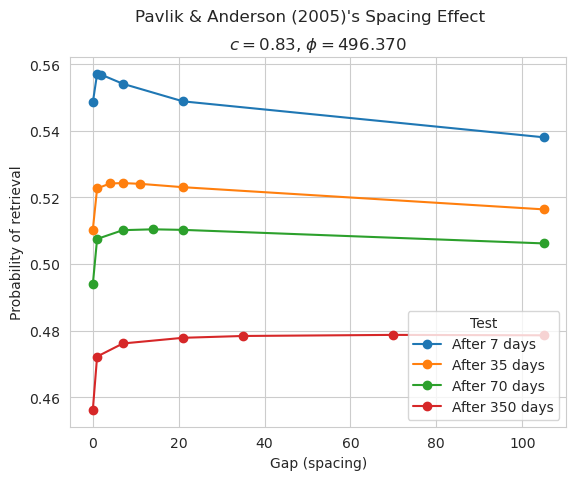

In [99]:
results = {}
d_default = 0.8
c_default = 0.01
daysec=24

def pavlik(design, d=d_default, c=c_default):
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t = (ri + gap)*daysec
            t1 = 0
            t2 = gapsec
            odds1 = (t - t1)**-d
            prob1 = odds1 / (odds1 + 1)
        
            d2 = c * t2**-d + d
        
            odds2 = (t - t2)**-d2 
            odds = odds1 + odds2
            prob = odds / (odds + 1)
            ri_results.append(prob)
        results[ri] = ri_results
    return results



def pavlikMSE(x):
    """Function for global optimization"""
    global design 
    c, d = x
    results = pavlik(design, c=c, d=d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE
                        
pavlik_best = minimize(pavlikMSE, x0 = [0.5, 0.5], bounds=[[0.0001, 1], [0.00001, 1]], method="Powell")

results = pavlik(design, c=pavlik_best.x[0], d=pavlik_best.x[1])

for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
plt.legend(labels=["After %d days" % (x,) for x in design.keys()],
           title="Test", loc="lower right")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Pavlik & Anderson (2005)'s Spacing Effect")
plt.title("$c = %.2f$, $\phi = %.3f$" % (best.x[0], best.x[1]))
plt.show()

## Visualization Against Real Data

[0.5485234488851172, 0.5570856468432964, 0.5568429538864061, 0.5541219262313128, 0.5488523907601554, 0.5380589017641141]
[0.5103221319122175, 0.5226950081641966, 0.5241873504053608, 0.524314035473777, 0.5240858937917157, 0.5230765245827655, 0.5164154959905821]
[0.4939189173100823, 0.5075350795044609, 0.5101753207086194, 0.5104277114874834, 0.5102621682492392, 0.5061972148708044]
[0.4562005858183179, 0.4722248117233185, 0.4761503381631712, 0.4778551029964101, 0.4784033531651795, 0.4787288027936216, 0.47860333743338024]


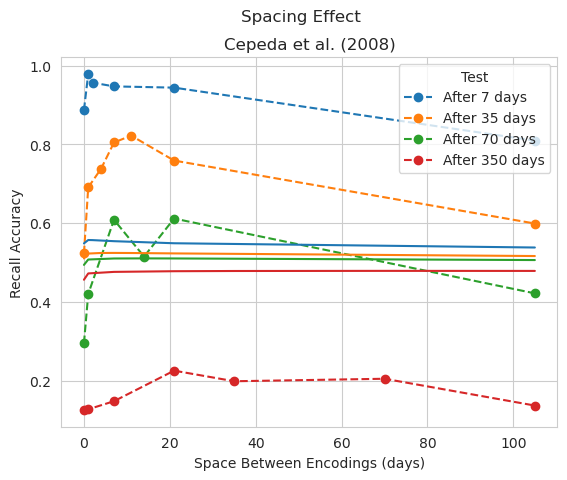

In [102]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]],
          loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Cepeda et al. (2008)")
fig.suptitle("Spacing Effect")

results = pavlik(design, c=pavlik_best.x[0], d=pavlik_best.x[1])
plt.gca().set_prop_cycle(None)
for ri in design.keys():
    x = design[ri]
    y = results[ri]
    print(y)
    ax.plot(x, y, "-")
plt.show()

# Alternative Model Based on Free Energy 

In this version, different traces share the same decay rate but have different _weights_:

$$A(m, t) = \log \sum_i w_i  (t - t_i)^{-d} $$

The $i$-th trace's weight $w_i$ is calculated as the _surprisal_ of memory _m_ at time $t_i$, that is:

$$ w_i = -\log P(m, t_i) $$

Because the activation of a memory is formally defined as its log odds, the probability of retrieving a memory $m$ is given by:

$$ P(m, t) = \frac{e^{A(m, t)}}{1 + e^{A(m,t)}} = \frac{1}{1 + e^{-A(m,t)}} $$

Thus, the weight can be expressed as:

$$ w_i = -\log \left( \frac{1}{1 + e^{-A(m,t)}} \right) = \log (1 + e^{-A(m, t)}) $$

Which is the softplus (continuos ReLU) function of $-A(m, t)$.

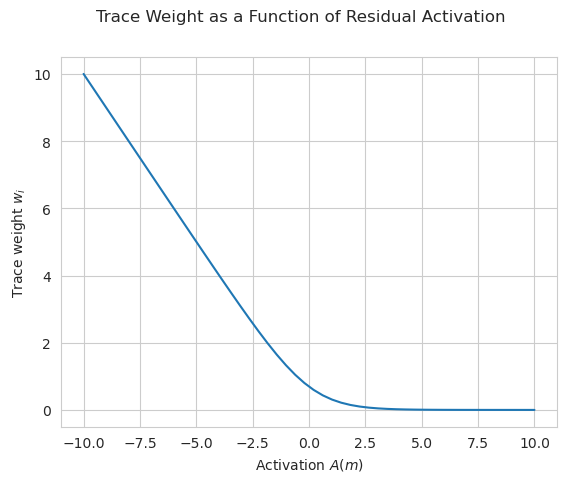

In [9]:
Am = np.linspace(-10, 10)
weights = np.log(1 + np.exp(-Am)) 

plt.plot(Am, weights)
plt.xlabel("Activation $A(m)$")
plt.ylabel("Trace weight $w_i$") 
plt.suptitle("Trace Weight as a Function of Residual Activation") 
plt.show()

This model can easily reproduce Cepeda's data

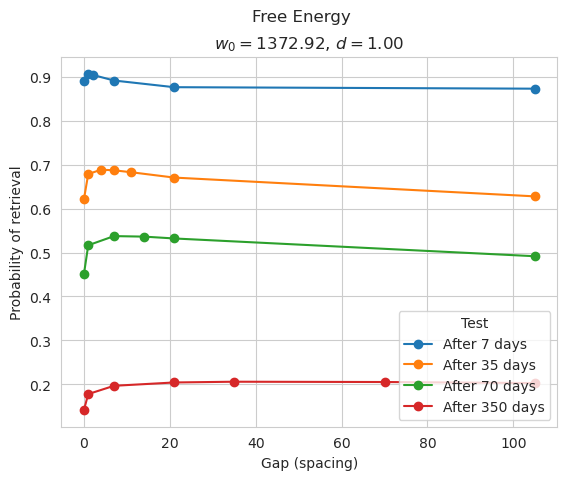

In [121]:
results = {}

d_default = 0.3
w_default = 10

daysec=24


def free_energy(design, d = d_default, w0 = w_default):
    results = {}
    for ri in design.keys():
        ri_results = []
        gaps = design[ri]
        for gap in gaps:
            risec = ri * daysec
            gapsec = gap * daysec
            t1 = 0
            t2 = gapsec
            t3 = risec + gapsec
        
            # Traces
        
            trace1 = (t3 - t1)**-d  # Trace 1 at time t
            trace2 = (t3 - t2)**-d  # Trace 2 at time t 
        
            # Weights
        
            w1 = w0 
        
            A_t2 = log((t2 - t1)**-d)
            w2 = log(1 + exp(-A_t2)) * (w0/10)
                
            A_t = log(w1 * trace1 + w2 * trace2)
            prob = exp(A_t) / (1 + exp(A_t))
            ri_results.append(prob)
        results[ri] = ri_results
    return results


def feMSE(x):
    """Function for global optimization"""
    global design 
    d, w0 = x
    results = free_energy(design, w0=w0, d=d)
    MSE = 0.0
    for ri in design.keys():
        predicted = np.array(results[ri])
        observed = np.array(cepeda.Accuracy[cepeda.RI == ri])
        MSE += np.sum((predicted - observed)**2)
    return MSE


fe_best = minimize(feMSE, x0 = [0.5, 5], bounds=[[0.0001, 1], [0, 10000]], method="Powell")

results = free_energy(design, d=fe_best.x[0], w0=fe_best.x[1])


for ri in design.keys():
    x = design[ri]
    y = results[ri]
    plt.plot(x, y, "o-")
    
plt.legend(labels=["After %d days" % (x,) for x in design.keys()], title="Test", loc="lower right")
plt.xlabel("Gap (spacing)")
plt.ylabel("Probability of retrieval")
plt.suptitle("Free Energy")
plt.title("$w_0 = %.2f$, $d = %.2f$" % (fe_best.x[1], fe_best.x[0]))
plt.show()

## Visualization

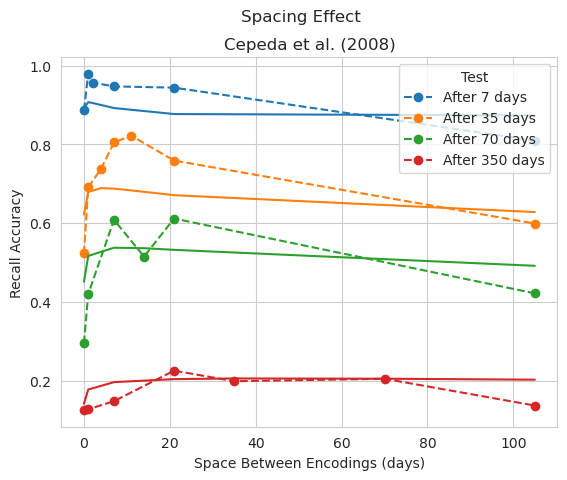

In [122]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]],
          loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Cepeda et al. (2008)")
fig.suptitle("Spacing Effect")

results = free_energy(design, d=fe_best.x[0], w0=fe_best.x[1])

plt.gca().set_prop_cycle(None)
for ri in design.keys():
    x = design[ri]
    y = results[ri]
    ax.plot(x, y, "-")
plt.show()

# Model Comparison

## Parameter Space Partitioning (PSP)
Space
A simple way to examine the model is Parameter Space Partitioning (PSP). In this case, we compute how many discrete patterns are generated by the model across parameters.

The key in the spacing effect is that all patterns have a _quadratic_ form, i.e., there is a peak in the middle. This is in contrast to a monotonic descending pattern (where the peak is on the first data point) and the monotonic ascending pattern (where the peak is at the end).

So, we can code the different patterns as follows:

* 0 = All curves are quadratic (correct predictions)
* 1 = Some curves are quadratic
* 2 = No curve is quadratic

In [129]:
from scipy.signal import find_peaks    

seq1 = [1, 2, 3, 4]
seq2 = [4, 3, 2, 1]
seq3 = [1, 2, 3, 2, 1]
seq4 = [1, 2, 1, 2, 1]

def categorize(results):
    sequences = [x[1] for x in results.items()]
    peaks = [find_peaks(seq)[0] for seq in sequences]
    npeaks = [x.shape[0] for x in peaks]
    
    N = len([n for n in npeaks if n > 0])
    K = len(results.keys())
        
    if N == K:
        return 0
    elif N > 0:
        return 1
    else:
        return 2
                    
        
categorize(results)

0

In [134]:
categorize(free_energy(design, w0=500, d=0.8))

0

2.0


/tmp/ipykernel_67606/468248113.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in d_space[0::20]])
/tmp/ipykernel_67606/468248113.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::20]])


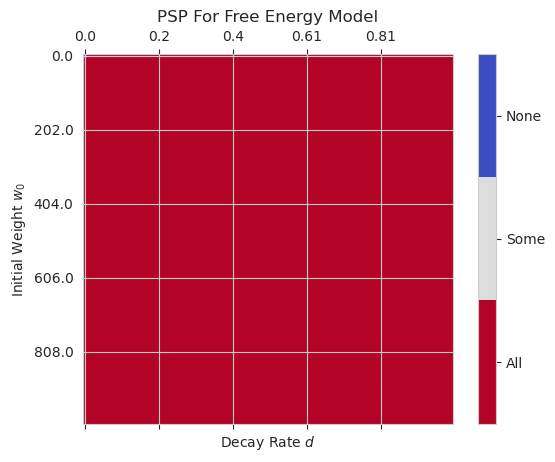

In [138]:
cmap = plt.get_cmap('coolwarm_r', 3)    
w_space = np.linspace(0.00001, 1000, 100) # Y axis
d_space = np.linspace(0.0001, 1.0001, 100) # X Axis

S = np.zeros((len(w_space), len(d_space)))

for i, w0 in enumerate(w_space):
    for j, d in enumerate(d_space):
        res = free_energy(design, d=d, w0=w0)
        S[i, j] = categorize(res)

S[0,0]=2
print(np.sum(S))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap=cmap)
fig.colorbar(cax, ticks=[1/3, 1, 5/3], format=FixedFormatter(["All", "Some", "None"]))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in d_space[0::20]])
ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::20]])
ax.set_ylabel("Initial Weight $w_0$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("PSP For Free Energy Model")
plt.show()
plt.show()

/tmp/ipykernel_138373/3299814072.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in d_space[0::100]])
/tmp/ipykernel_138373/3299814072.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in c_space[0::100]])


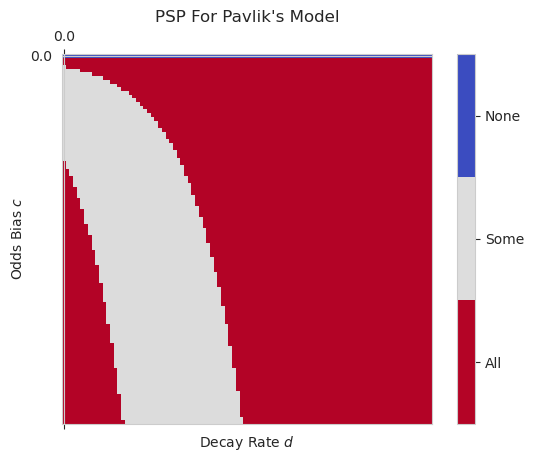

In [13]:
c_space = np.linspace(0, 1, 100)
d_space = np.linspace(0.0001, 1.0001, 100)

S = np.zeros((len(c_space), len(d_space)))

for i, c in enumerate(c_space):
    for j, d in enumerate(d_space):
        res = pavlik(design, d=d, c=c)
        S[i, j] = categorize(res)
             
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap=cmap)
fig.colorbar(cax, ticks=[1/3, 1, 5/3], format=FixedFormatter(["All", "Some", "None"]))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.set_xticklabels([''] + [str(round(x, 2)) for x in d_space[0::100]])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in c_space[0::100]])
ax.set_ylabel("Odds Bias $c$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("PSP For Pavlik's Model")
plt.show()
plt.show()

## Size of spacing effect across parameters

In [114]:

def se_size(results):
    sequences = [x[1] for x in results.items()]
    size = 0.0
    for seq in sequences:
        peaks = find_peaks(seq)[0]    
        N = len(peaks)
        
        if N == 1:
            baseline = seq[0]
            peak = seq[peaks[0]]
            size += (peak - baseline)/baseline
    return size

se_size(results)

0.46279969679650085

/tmp/ipykernel_67606/1041319690.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::40]])
/tmp/ipykernel_67606/1041319690.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::40]])


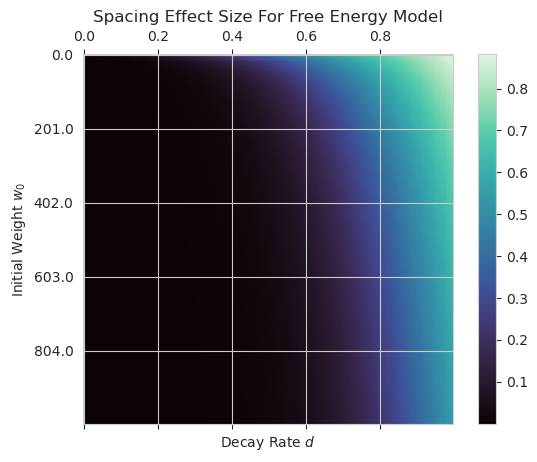

In [115]:
w_space = np.linspace(0.0001, 1000, 200) # Y axis
d_space = np.linspace(0.0001, 1.0001, 200) # X Axis

S = np.zeros((len(w_space), len(d_space)))

for i, w0 in enumerate(w_space):
    for j, d in enumerate(d_space):
        res = free_energy(design, d=d, w0=w0)
        S[i, j] = se_size(res)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap="mako")
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(40))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::40]])
ax.set_yticklabels([''] + [str(round(x, 0)) for x in w_space[0::40]])
ax.set_ylabel("Initial Weight $w_0$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("Spacing Effect Size For Free Energy Model")
plt.show()
plt.show()

/tmp/ipykernel_138373/424335013.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::20]])
/tmp/ipykernel_138373/424335013.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 1)) for x in c_space[0::20]])


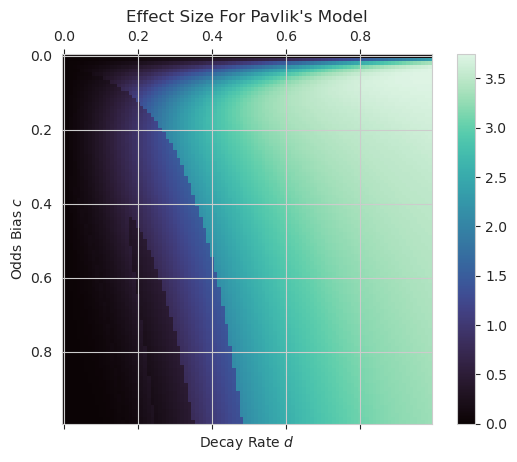

In [41]:
c_space = np.linspace(0, 1, 100)
d_space = np.linspace(0.0001, 1.0001, 100)

S = np.zeros((len(c_space), len(d_space)))

for i, c in enumerate(c_space):
    for j, d in enumerate(d_space):
        res = pavlik(design, d=d, c=c)
        S[i, j] = se_size(res)
             
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(S, interpolation='nearest', cmap="mako")
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.set_xticklabels([''] + [str(round(x, 1)) for x in d_space[0::20]])
ax.set_yticklabels([''] + [str(round(x, 1)) for x in c_space[0::20]])
ax.set_ylabel("Odds Bias $c$")
ax.set_xlabel("Decay Rate $d$")
ax.set_title("Effect Size For Pavlik's Model")
plt.show()
plt.show()

# Neural Network Implementation

We can think of the hippocampus as a neural network

## A Hopfield network exhibits power law of forgetting  

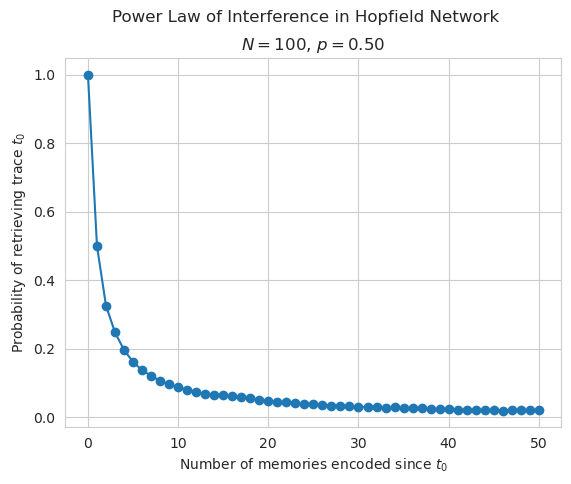

In [141]:
N = 100

P = 0.5

W = np.zeros((N, N))

def generate_memory(n=N, p=P):
    memory = stats.binom.rvs(1, P, size=N)
    memory[memory == 0] = -1
    return memory



def learn(memory):
    """Learn a pattern"""
    global W
    for i in range(N):
        for j in range(i+1, N):
            wij = memory[i] * memory[j]
            W[i,j] += 1/N * wij
            

def calculate_energy(memory):
    """Calculates the energy of the given memory"""
    H = 0
    for i in range(N):
        for j in range(N):
            H += W[i,j] * memory[i] * memory[j]
    return H


def calculate_probability(memory, memories, temperature=25):
    num = np.exp(calculate_energy(memory)/temperature)
    denom = np.sum([np.exp(calculate_energy(x)/temperature) for x in memories])
    return num/denom

memory = generate_memory()

learn(memory)
calculate_energy(memory)

memories = [memory]

results = [calculate_probability(memory, memories)]

weights = [np.sum(W)]

for n in range(50):
    new = generate_memory()
    memories.append(new)
    learn(new)
    results.append(calculate_probability(memory, memories))
    weights.append(np.sum(W))
    
plt.plot(results, "o-")
plt.xlabel("Number of memories encoded since $t_0$")
plt.ylabel("Probability of retrieving trace $t_0$")
plt.suptitle("Power Law of Interference in Hopfield Network" )
plt.title("$N = %d$, $p = %.2f$" % (N, P))
plt.show()



Also, synpatic weights tend to be stable

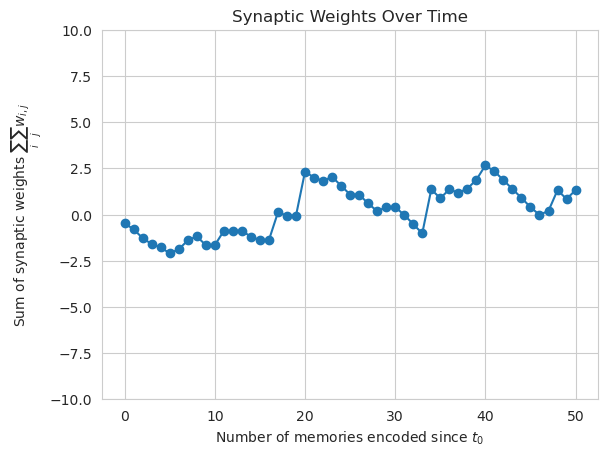

In [134]:
plt.plot(weights, "o-")
plt.ylim(-10, 10)
plt.xlabel("Number of memories encoded since $t_0$")
plt.ylabel("Sum of synaptic weights $\sum_i \sum_j w_{i,j}$")
plt.title("Synaptic Weights Over Time")
plt.show()

## Runaway activation due to retrievals

Similarly, a Hopfield model suffers from runaway activation due to retrievals

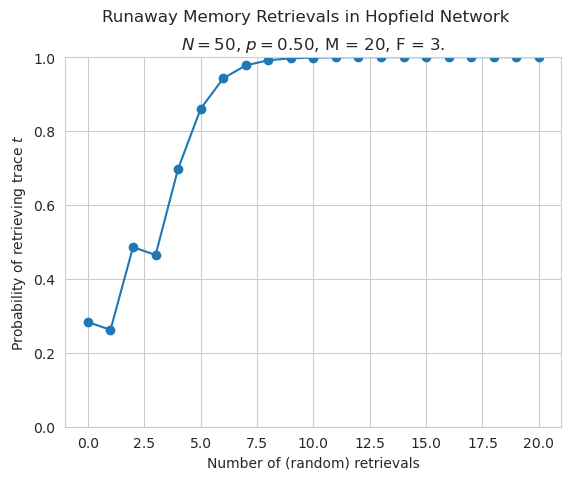

In [160]:
N = 50
P = 0.5
M = 20   # Number of memories
F = 3    # Frequencyt
W = np.zeros((N, N))

def retrieve(memories):
    probabilities = [calculate_probability(x, memories) for x in memories]
    return random.choices(memories, weights=probabilities, k=1)[0]

memory = generate_memory()
memories = [memory]


# Learn 19 other memories

for i in range(M-1):
    new = generate_memory()
    learn(new)
    memories.append(new)
    
# Over-retrieve the original memory

for i in range(3):
    learn(memory)

results = [calculate_probability(memory, memories)]

for n in range(20):
    retrieved = retrieve(memories)
    learn(retrieved)
    results.append(calculate_probability(memory, memories))

    
plt.plot(results, "o-")
plt.ylim(0, 1)
plt.xlabel("Number of (random) retrievals")
plt.ylabel("Probability of retrieving trace $t$")
plt.suptitle("Runaway Memory Retrievals in Hopfield Network")
plt.title("Runaway Memory Retrievals in Hopfield Network")
plt.title("$N = %d$, $p = %.2f$, M = %d, F = %d." % (N, P, M, F))
plt.show()

## Stabilizing effect of free energy

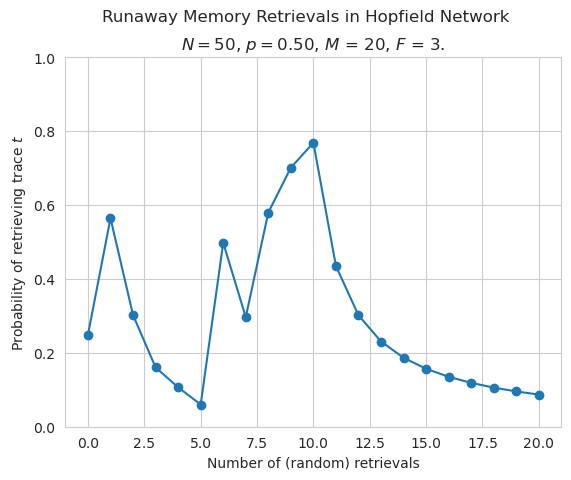

In [158]:
N = 50
P = 0.5
M = 20
F = 3
W = np.zeros((N, N))

def learn2(memory, memories):
    """Learn a pattern"""
    global W
    prob = calculate_probability(memory, memories)
    fnrg = -np.log(prob)
    for i in range(N):
        for j in range(i+1, N):
            wij = fnrg * memory[i] * memory[j]
            W[i,j] += 1/N * wij


memory = generate_memory()
memories = [memory]


# Learn 19 other memories

for i in range(M-1):
    new = generate_memory()
    learn(new)
    memories.append(new)
    
# Over-retrieve the original memory

for i in range(F):
    learn(memory)

results = [calculate_probability(memory, memories)]

for n in range(20):
    retrieved = retrieve(memories)
    learn2(retrieved, memories)
    results.append(calculate_probability(memory, memories))

    
plt.plot(results, "o-")
plt.xlabel("Number of (random) retrievals")
plt.ylabel("Probability of retrieving trace $t$")
plt.ylim(0,1)
plt.suptitle("Runaway Memory Retrievals in Hopfield Network")
plt.title("Runaway Memory Retrievals in Hopfield Network")
plt.title("$N = %d$, $p = %.2f$, $M$ = %d, $F$ = %d." % (N, P, M, F))
# Ol plt.show()

# Old Ideas

## Spacing by unobserved retrievals

/tmp/ipykernel_138373/980766772.py:3: RuntimeWarning: divide by zero encountered in power
  odds = T**d
/tmp/ipykernel_138373/980766772.py:4: RuntimeWarning: invalid value encountered in divide
  probs = odds/(1 + odds)


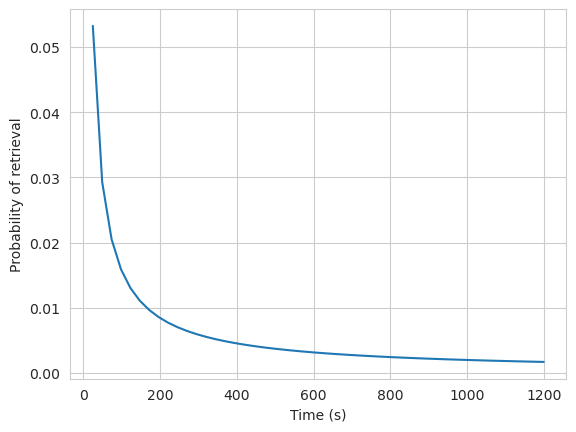

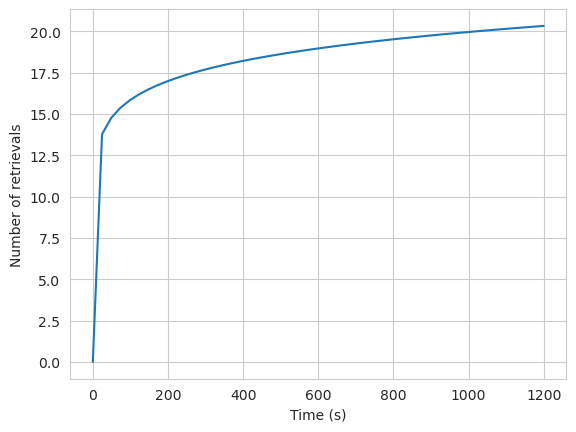

In [15]:
T = np.linspace(0, 1200)
d = -0.9
odds = T**d
probs = odds/(1 + odds)
plt.plot(T, probs)
plt.xlabel("Time (s)")
plt.ylabel("Probability of retrieval")
plt.show()

cmvl = (T**(d + 1)) / (d + 1)
plt.plot(T, cmvl)
plt.xlabel("Time (s)")
plt.ylabel("Number of retrievals")
plt.show()

In [16]:
def new_trace_odds(t, d=-0.4):
    X = np.linspace(0, t, endpoint=False)    
    integral = 0
    for x in X:
        if (x > 0):
            odds = x ** d
            prob = odds / (1 + odds)
            integral += prob * ((t-x)**d)
    return integral
        

def old_trace_odds(t, d=-0.3):
    return t ** d
    
res = []
T = np.linspace(0, 100000, 100)
for i in T:
    res += [real_trace_odds(i)]
plt.plot(T, res)
plt.show()

gaps = [10, 100, 1000, 10000, 10000]
retention = 20000

old = []
for gap in gaps:
    endtime = gap + retention
    t1 = old_trace_odds(endtime)
    t2 = old_trace_odds(retention)
    activation = np.log(t1 + t2)
    old += [activation]
    
plt.plot(gaps, old, "o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()

new = []
for gap in gaps:
    endtime = gap + retention
    t1 = new_trace_odds(endtime)
    t2 = new_trace_odds(retention)
    activation = np.log(t1 + t2)
    new += [activation]

plt.plot(gaps, new, "o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()

NameError: name 'real_trace_odds' is not defined

In [ ]:
def estimated_number_retrievals(t, d=-0.8):
    """This is the anti-derivative of the odds function"""
    return t**(d + 1) / (d + 1) 
    
    
def cumulative_trace_odds(t, d=-0.8):
    """Real effect of a trace, assuming N retrievals were spawned"""
    n = estimated_number_retrievals(t, d)
    return np.log(n / (1 + d)) + d * np.log(t)


gaps = [1, 10, 100, 1000]
retention = 1000

old = []
for gap in gaps:
    endtime = gap + retention
    t1 = old_trace_odds(endtime)
    t2 = old_trace_odds(retention)
    activation = np.log(t1 + t2)
    old += [activation]
    
plt.plot(gaps, old, "o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()

new = []
for gap in gaps:
    endtime = gap + retention
    n1 = estimated_number_retrievals(endtime)
    n2 = estimated_number_retrievals(retention)
    activation = cumulative_trace_odds(n1 + n2)
    new += [activation]

plt.plot(gaps, new, "o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()



In [ ]:
# The mean of a poisson distribution is lambda, which
# is approximated as 
#   
#     lambda = r*t
#
# where r = rate of events per time unit
#       t = duration of the interval

rate = 1 / (60 * 10)

def cumulative_traces(t, d=-0.6):
    X = np.linspace(0, t, 1000, endpoint=False)    
    integral = 0
    previous = 0
    for x in X:
        if (x > 0):
            odds = x ** d
            prob = odds / (1 + odds)
            echoes = prob * rate * (x - previous)
            previous = x
            integral += echoes * (t - x)**d
    return integral 



def old_trace_odds(t, d=-0.6):
    return t ** d
    
res = []
T = np.linspace(0, 100000, 100)
for i in T:
    res += [real_trace_odds(i)]
plt.plot(T, res)
plt.show()

gaps = [10, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 30 * 365]
gap_names = ["1min", "1 hr", "1 day", "1 month", "1 year"]
retention = 60 * 60 * 24

old = []
for gap in gaps:
    endtime = gap + retention
    t1 = old_trace_odds(endtime)
    t2 = old_trace_odds(retention)
    activation = np.log(t1 + t2)
    old += [activation]
    
plt.plot(gap_names, old, "-o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()

new = []
for gap in gaps:
    endtime = gap + retention
    t1 = cumulative_traces(endtime)
    t2 = cumulative_traces(retention)
    activation = np.log(t1 + t2)
    new += [activation]

plt.plot(gap_names, new, "-o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()


In [ ]:
# Now, teh full might, with integral over echoes of echoes of echoes

rate = 1 / (60 * 10)

def cumulative_traces(t, d=-0.43):
    X = np.linspace(0, t, endpoint=False)    
    integral = 0
    previous = 0
    echoes = [1]
    current_odds = 0
    for x in X:
        if x > 0:
            odds = x ** d
            prob = odds / (1 + odds) # probability of the original trace
            newechoes = prob * rate * (x - previous) # new echoes of the original trace
            previous = x
            echoes += [newechoes]
    
    for x, n in zip(X, echoes):
        integral += n * (t - x)**d
    
    return integral 



def old_trace_odds(t, d=-0.6):
    return t ** d
    
res = []
T = np.linspace(0, 100000, 100)
for i in T:
    res += [real_trace_odds(i)]
plt.plot(T, res)
plt.show()

gaps = [10, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 30 * 365]
gap_names = ["1min", "1 hr", "1 day", "1 month", "1 year"]
retention = 60 * 60 * 24

old = []
for gap in gaps:
    endtime = gap + retention
    t1 = old_trace_odds(endtime)
    t2 = old_trace_odds(retention)
    activation = np.log(t1 + t2)
    old += [activation]
    
plt.plot(gap_names, old, "-o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()

new = []
for gap in gaps:
    endtime = gap + retention
    t1 = cumulative_traces(endtime)
    t2 = cumulative_traces(retention)
    activation = np.log(t1 + t2)
    new += [activation]

plt.plot(gap_names, new, "-o")
plt.xlabel("Spacing (Gap)")
plt.ylabel("Activation")
plt.show()
